# 1. Модели скользящего среднего (МА-модели)

## 1.1 Введение

Вместо прошлых значений прогнозируемой переменной модель скользящего среднего использует прошлые ошибки прогноза. Модель скользящего среднего порядка q или MA(q)-модель можно записать следующим образом:

$$y_t=c+\epsilon_t+\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}+...+\theta_q\epsilon_{t-q}$$

где 
- c - константа, 
- $\theta_1,...,\theta_p$ - параметры модели
- $\epsilon_t$ - белый шум.

Конечно, мы не можем наблюдать значения $\epsilon_t$, поэтому здесь нельзя говорить о регрессии в обычном смысле. Обратите внимание, что каждое значение можно рассматривать как взвешенное скользящее среднее нескольких последних ошибок прогноза. Однако модели скользящего среднего не следует путать со сглаживанием на основе скользящего среднего и моделью скользящего среднего, которая прогнозирует с помощью скользящего среднего N последних наблюдений, где N - размер скользящего окна, и используется для построения базовой модели.

На рисунке ниже показаны МА(1)-модель и МА(2)-модель. Изменение параметров $\theta_1,...,\theta_p$ приведет к различным паттернам временных рядов. Как и в случае с авторегрессионными моделями, дисперсия ошибки изменит только масштаб значений временного ряда, но не паттерны временного ряда.

- MA(1): $y_t=20+\epsilon_t+0.8\epsilon_{t-1}$

![image.png](attachment:image.png)

- MA(2): $y_t=\epsilon_t-\epsilon_{t-1}+0.8\epsilon_{t-2}$

![image-2.png](attachment:image-2.png)

Специального класса для построения MA-моделей в библиотеки Statsmodels нет, однако их можно построить с помощью класса ARMA (начиная с версии 0.12 считается устаревшим), задав ARMA(0,q), или с помощью класса ARIMA, задав ARIMA(0,0,q).

Для работы снова загрузим набор данных FEDFUNDS.csv, содержащий информацию о процентной ставке по федеральным фондам с июля 1954 года по февраль 2021 года. Оставим данные только до 2008 года.

In [ ]:
# импортируем необходимые библиотеки, классы и функции
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [ ]:
# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# настроим удобное отображение графиков и таблиц
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

In [ ]:
# загрузим данные
s = pd.read_csv(
    './data/FEDFUNDS.csv', 
    header=0, 
    index_col=0, 
    parse_dates=True, 
    squeeze=True)

# оставим данные только до 2008 года
s = s[:'2007']

Разбиваем набор данных на обучающую и тестовую выборки так, чтобы в тестовой выборке оказалось 7 наблюдений.

In [ ]:
# разобьем данные на обучающую и тестовую выборки так,
# чтобы в тесте оказалось 7 наблюдений
X = s.values
train, test = X[0:len(X)-7], X[len(X)-7:]

Теперь обучаем модель скользящего среднего на обучающей выборке, задав ARIMA(0,0,1), т.е. MA(1)-модель.

In [ ]:
# обучим MA(1)-модель
model = ARIMA(train, order=(0, 0, 1))
model_fit = model.fit()

Давайте выведем сводку о построенной модели.

In [ ]:
# выведем сводку по модели
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  635
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1271.596
Date:                Tue, 11 Oct 2022   AIC                           2549.191
Time:                        19:01:59   BIC                           2562.552
Sample:                             0   HQIC                          2554.379
                                - 635                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6950      0.173     32.835      0.000       5.355       6.035
ma.L1          0.9354      0.009    102.774      0.000       0.918       0.953
sigma2         3.2023      0.150     21.326      0.000       2.908       3.497
===================================================================================
Ljung-Box (L1) (Q):                 468.80   Jarque-Bera (JB):               376.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# выведем константу и коэффициенты модели с помощью атрибута .params
coef = model_fit.params
print('Константа и коэффициенты:\n\n%s' % coef)

Константа и коэффициенты:

[5.69496955 0.93539622 3.20231277]


In [ ]:
# взглянем, как был получен первый прогноз
forecast_frst = coef[0] + (model_fit.resid[-1:] * coef[1])[0]
forecast_frst

5.517907572161527

In [ ]:
# делаем прогнозы на 7 временных шагов вперед
# для этого в методе .predict() задаем начало и конец 
# периода прогнозирования
predictions = model_fit.predict(
    start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [ ]:
# напечатаем прогнозы на 7 временных шагов вперед
for i in range(len(predictions)):
    print('спрогнозированное=%f, фактическое=%f' % (predictions[i], test[i]))
# вычислим значение метрики RMSE
rmse = np.sqrt(
    mean_squared_error(test, predictions))

print('\nRMSE на тестовой выборке: %.3f' % rmse)

спрогнозированное=5.517908, фактическое=5.250000
спрогнозированное=5.694970, фактическое=5.260000
спрогнозированное=5.694970, фактическое=5.020000
спрогнозированное=5.694970, фактическое=4.940000
спрогнозированное=5.694970, фактическое=4.760000
спрогнозированное=5.694970, фактическое=4.490000
спрогнозированное=5.694970, фактическое=4.240000

RMSE на тестовой выборке: 0.905


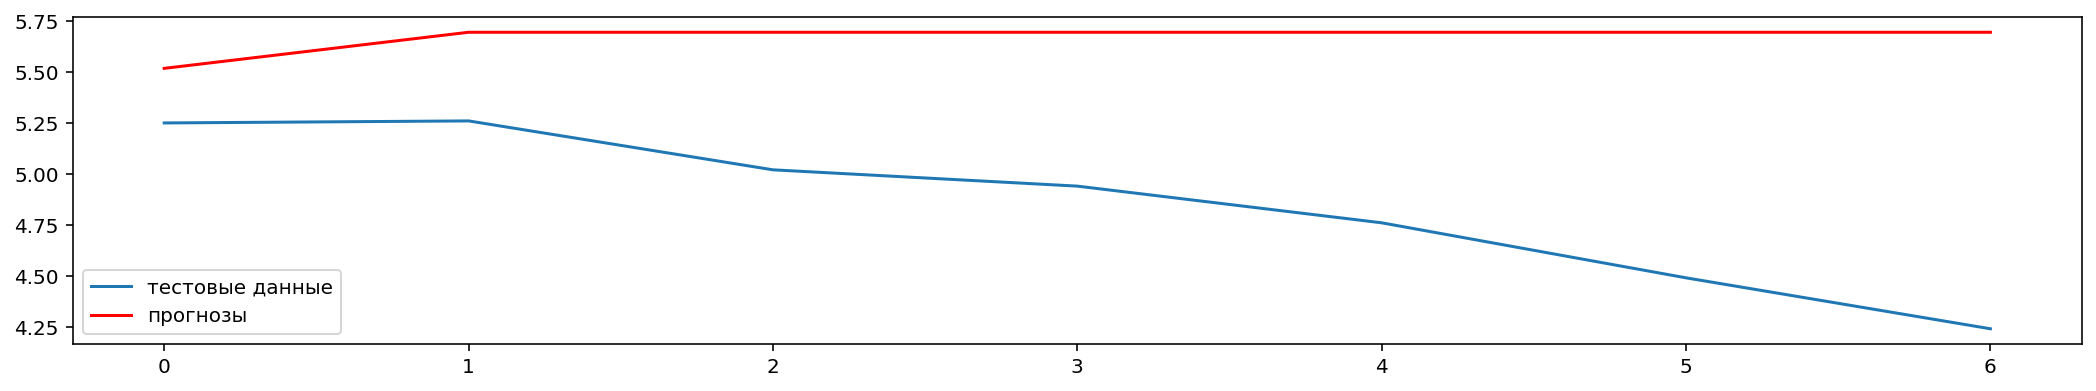

In [ ]:
# визуализируем прогнозы
plt.plot(test, label='тестовые данные')
plt.plot(predictions, color='red', label='прогнозы')
plt.legend();